# Bag of N-grams Model on IMDB Reviews

__Inport these modules__

In [257]:
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

__Read in the training data from two folders named pos and neg__

In [258]:
#Data Source: http://ai.stanford.edu/~amaas/data/sentiment/
#Read positive reviews with label pos in training data
files_pos = []
dir1 = '../aclImdb/train/pos/'
for f in os.listdir(dir1):
    files_pos.append([open(dir1+f).read(),1])  #hard-code positive review as 1. This is important!!

#Read Negative reviews with label neg in training data
files_neg = []
dir2 = '../aclImdb/train/neg/'
for f in os.listdir(dir2):
    files_neg.append([open(dir2+f).read(),0])


__Merge two lists and shuffle it so that we can divide them into train and val later__

In [259]:
from random import sample
files_train = files_neg+files_pos
files_train = sample(files_train, len(files_train))

__Split train data into actual train and validation sets__

In [260]:
train_split = 20000
train_data_0, train_targets_0 = zip(*files_train)
train_data = train_data_0[:train_split]
train_targets = train_targets_0[:train_split]

val_data = train_data_0[train_split:]
val_targets = train_targets_0[train_split:]


__The first tokenization is just the one from lab3. The second one just adds STOP-WORDS to the one from lab3. After experiementing these two schemes, second scheme gives a higher validation accuracy, so we'll choose the second scheme__

In [268]:
# Let's write the tokenization function with STOP-WORDS scheme

import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations and token.text not in STOP_WORDS)]

In [269]:
#tokenization

import pickle as pkl

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)   # a list
        token_dataset.append(tokens)  #take the list as the first entry
        all_tokens += tokens    # literally all tokens one by one 

    return token_dataset, all_tokens

# train set tokens
print('Tokenizing train data')
train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

#val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data)
pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))



Tokenizing train data
Tokenizing val data


__Create the vocabulary with some vocabulary size__

In [282]:
# Now we're going to create the vocabulary

from collections import Counter
# max_vocal_size =10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    
    token_counter = Counter(all_tokens) #find the counts of each token
    vocab, count = zip(*token_counter.most_common(max_vocab_size))  #zip Make an iterator that aggregates elements from each of the iterables.
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) #starts from 2 because PAD_IDX and UNK-IDX
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

#token2id, id2token = build_vocab(all_train_tokens)

__One-hot Code the tokens. This gives a vector of indices of tokens in review__

In [283]:
# convert token to id in the dataset within vacabulary built above

def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

#train_data_indices = token2index_dataset(train_data_tokens) # each element is a list of indices of a line of tokens.
#val_data_indices = token2index_dataset(val_data_tokens)

# double checking
#print ("Train dataset size is {}".format(len(train_data_indices)))
#print ("Val dataset size is {}".format(len(val_data_indices)))

__Create the Pytorch Dataloader__

In [345]:
import numpy as np
import torch
from torch.utils.data import Dataset 

MAX_SENTENCE_LENGTH = 200
class IMDBdataset(Dataset):
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of movie review tokens 
        @param target_list: list of movie review targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]  
    
def IMDB_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.LongTensor(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]
# create pytorch dataloader
#train_loader = IMDBdataset(train_data_indices, train_targets)
#val_loader = IMDBdataset(val_data_indices, val_targets)
#test_loader = IMDBdataset(test_data_indices, test_targets)

# BATCH_SIZE = 32
# train_dataset = IMDBdataset(train_data_indices, train_targets)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=IMDB_collate_func,
#                                            shuffle=True)

# val_dataset = IMDBdataset(val_data_indices, val_targets)
# val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=IMDB_collate_func,
#                                            shuffle=True)


# for i, (data, lengths, labels) in enumerate(train_loader):
#     print (data)
#     print (labels)
#     break
    

__Define the bag of words model in Pytorch__

In [287]:
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)   #embedding size 100, 200, 500
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

#emb_dim = 100
#model = BagOfWords(len(id2token), emb_dim)


__Functions for testing the model__

In [288]:

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
#         predicted = torch.tensor([1 if x >= 0.5 else 0 for x in outputs[:, 1]]      )
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def train_model(model,
              lr = 0.01, 
              num_epochs = 5, 
              criterion = nn.CrossEntropyLoss()):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # wd: linear
    losses = []
    xs = 0
    val_accs = []
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            losses.append(loss)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                xs = xs + 100
                val_accs.append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    return losses, xs, val_accs

__Bag of n-grams__


In [289]:
def bag_of_ngrams(n, tokens):
    return zip(*[tokens[i:] for i in range(n)])

#generate unigram, bigram and combined one
unigrams = list(bag_of_ngrams(1, all_train_tokens))
bigrams = list(bag_of_ngrams(2, all_train_tokens))
combined =unigrams + bigrams

__Finally, let's run models with different hyperperameter settings!__

In [363]:
max_vocab_size = 10000
ngram = 1
embed_size = 500
LEARNING_RATE = 0.005
NUM_EPOCHS = 5

# Building the vocabulary
#Try different ngram
token2id, id2token = build_vocab(bag_of_ngrams(ngram, all_train_tokens))

# Check the dictionary
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

ngram_train_data_tokens = [list(bag_of_ngrams(ngram, review)) for review in train_data_tokens]
ngram_val_data_tokens = [list(bag_of_ngrams(ngram, review)) for review in val_data_tokens]


train_data_indices = token2index_dataset(ngram_train_data_tokens)
val_data_indices = token2index_dataset(ngram_val_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))

BATCH_SIZE = 32
train_dataset = IMDBdataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=True)

val_dataset = IMDBdataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=True)

Token id 4640 ; token ('catching',)
Token ('catching',); token id 4640
Train dataset size is 20000
Val dataset size is 5000


In [364]:
model = BagOfWords(len(id2token), embed_size)

losses, xs, val_accs = train_model(model,
          lr = LEARNING_RATE, 
          num_epochs = NUM_EPOCHS, 
          criterion = nn.CrossEntropyLoss())

Epoch: [1/5], Step: [101/625], Validation Acc: 82.16
Epoch: [1/5], Step: [201/625], Validation Acc: 85.62
Epoch: [1/5], Step: [301/625], Validation Acc: 86.96
Epoch: [1/5], Step: [401/625], Validation Acc: 85.26
Epoch: [1/5], Step: [501/625], Validation Acc: 87.54
Epoch: [1/5], Step: [601/625], Validation Acc: 87.42
Epoch: [2/5], Step: [101/625], Validation Acc: 87.74
Epoch: [2/5], Step: [201/625], Validation Acc: 87.28
Epoch: [2/5], Step: [301/625], Validation Acc: 87.0
Epoch: [2/5], Step: [401/625], Validation Acc: 87.06
Epoch: [2/5], Step: [501/625], Validation Acc: 87.22
Epoch: [2/5], Step: [601/625], Validation Acc: 87.0
Epoch: [3/5], Step: [101/625], Validation Acc: 87.4
Epoch: [3/5], Step: [201/625], Validation Acc: 87.1
Epoch: [3/5], Step: [301/625], Validation Acc: 86.72
Epoch: [3/5], Step: [401/625], Validation Acc: 86.72
Epoch: [3/5], Step: [501/625], Validation Acc: 86.64
Epoch: [3/5], Step: [601/625], Validation Acc: 86.4
Epoch: [4/5], Step: [101/625], Validation Acc: 86.3

In [365]:
len(losses)

3125

Text(0,0.5,'Val Acc')

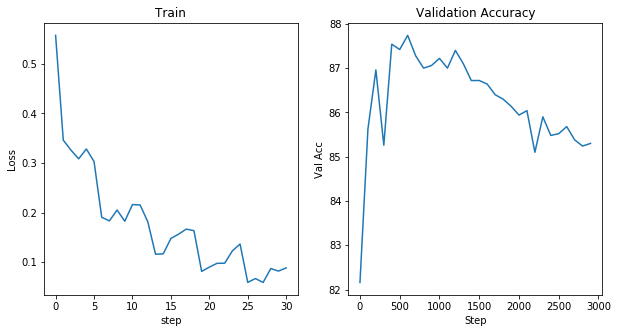

In [381]:
fig = plt.figure(figsize=(10, 5))

loss_avg_vals = []
for i in range(0, len(losses)-100, 100):
    loss = 0
    avg_loss = 0
    for j in range(i, i+100):
        loss += losses[j]
    avg_loss = loss/100.0
    loss_avg_vals.append(avg_loss)
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_avg_vals)), loss_avg_vals)
plt.title('Train')
plt.xlabel('step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(0, xs, 100), val_accs)
plt.title('Validation Accuracy')
plt.xlabel('Step')
plt.ylabel('Val Acc')

__Find 3 correct predictions and 3 wrong predictions__

In [386]:
model.eval()

eval_dataset = IMDBdataset(val_data_indices, val_targets)
eval_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                          batch_size=1,
                                          collate_fn=IMDB_collate_func,
                                          shuffle=False)

incorrect_data = []
correct_data = []
corr_count = 0
incorr_count = 0
i = 0
for data, lengths, labels in eval_loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        if (predicted.squeeze().item() == labels.squeeze().item() and incorr_count <= 2):
            incorr_count += 1
            incorrect_data.append(val_data[i])
        elif (predicted.squeeze().item() != labels.squeeze().item() and corr_count <= 2):
            corr_count += 1
            correct_data.append(val_data[i])
        i += 1
        
        if corr_count == 3 and incorr_count == 3:
            break

In [387]:
for i in range(len(correct_data)):
    print(correct_data[i] + '\n')

THE BRAIN THAT WOULDN'T DIE was considered so distasteful in 1959 that several cuts and the passage of three years was required before it was released in 1962. Today it is difficult to imagine how anyone could have taken the thing seriously even in 1959; the thing is both lurid and lewd, but it is also incredibly ludicrous in a profoundly bumptious sort of way.<br /><br />The story, of course, concerns a doctor who is an eager experimenter in transplanting limbs--and when his girl friend is killed in a car crash he rushes her head to his secret lab. With the aid of a few telephone cords, a couple of clamps, and what looks very like a shallow baking pan, he brings her head back to life. But is she grateful? Not hardly. In fact, she seems mightily ticked off about the whole thing, particularly when it transpires that the doctor plans to attach her head to another body.<br /><br />As it happens, the doctor is picky about this new body: he wants one built for speed, and he takes to cruisin

In [388]:
for i in range(len(incorrect_data)):
    print(incorrect_data[i] + '\n')

I really like Richard Gere...I always have and it seems as of late that his status as a Hollywood star and money maker has slipped but it would appear to me that the reason is that he is taking very mature, intense roles and has been very successful at it just not financially because I have seen him in some truly great gems as of late including The Hoax, The Hunting Party (both must see films! See my reviews) and now this The Flock which apparently was meant to be a big release considering it's substantial 35 million + budget. It seems that some of the other IMDb reviews are very, very harsh because I thought the film dealt with a potentially very serious social issue in a very direct, violent and disturbing way and Gere just brings it all home. It's an action thriller drama that kept my glued to the Television with it's story. I think part of the problem that people seem to have with it is that it Hollywood-izes a very serious issue but I don't think it does it with disrespect but rat

__Finally, let's find the accuracy on test set!__

In [374]:
files_pos = []
dir1 = '../aclImdb/test/pos/'
for f in os.listdir(dir1):
    files_pos.append([open(dir1+f).read(),1])  #hard-code positive review as 1. This is important!!

#Read Negative reviews with label neg in training data
files_neg = []
dir2 = '../aclImdb/test/neg/'
for f in os.listdir(dir2):
    files_neg.append([open(dir2+f).read(),0])

In [380]:
files_test = files_neg+files_pos
test_data, test_targets = zip(*files_test)

test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data)
pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))


In [378]:
ngram_test_data_tokens = [list(bag_of_ngrams(ngram, review)) for review in test_data_tokens]
test_data_indices = token2index_dataset(ngram_test_data_tokens)
print ("Test dataset size is {}".format(len(test_data_indices)))

test_dataset = IMDBdataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=False)

Test dataset size is 25000


In [385]:
print ("After training for {} epochs, the test Acc is {}".format(NUM_EPOCHS,test_model(test_loader, model)))

After training for 5 epochs, the test Acc is 83.032
